# Import Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
from math import sqrt





import os

import warnings
warnings.filterwarnings('ignore')

# Dataset

## Data Loading

In [35]:
df = pd.read_csv("NFLX.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900
6,2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
7,2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
8,2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
9,2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400


In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1009.0,4.190597e+02,1.085375e+02,2.339200e+02,3.314900e+02,3.777700e+02,5.091300e+02,6.923500e+02
High,1009.0,4.253207e+02,1.092630e+02,2.506500e+02,3.363000e+02,3.830100e+02,5.156300e+02,7.009900e+02
Low,1009.0,4.123740e+02,1.075559e+02,2.312300e+02,3.260000e+02,3.708800e+02,5.025300e+02,6.860900e+02
Close,1009.0,4.190007e+02,1.082900e+02,2.338800e+02,3.316200e+02,3.786700e+02,5.090800e+02,6.916900e+02
Adj Close,1009.0,4.190007e+02,1.082900e+02,2.338800e+02,3.316200e+02,3.786700e+02,5.090800e+02,6.916900e+02
Volume,1009.0,7.570685e+06,5.465535e+06,1.144000e+06,4.091900e+06,5.934500e+06,9.322400e+06,5.890430e+07


## Data Preparation

In [37]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Check stationarity
adf_test(df['Close'])


ADF Statistic: -1.812590687828996
p-value: 0.3742289256820758
Critical Values: {'1%': -3.436893045520188, '5%': -2.8644287878535146, '10%': -2.568308127138936}


# Linear Regression

In [38]:
# Extract 'Date' and 'Close' columns
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
X_single = (df['Date'] - df['Date'].min()) / pd.Timedelta(days=1)  # Convert 'Date' to numeric format
y_single = df['Close']

# Split the data sequentially into training, validation, and test sets (80:10:10)
train_size_single = int(0.8 * len(df))
val_size_single = int(0.1 * len(df))

X_train_single = X_single[:train_size_single]
y_train_single = y_single[:train_size_single]

X_val_single = X_single[train_size_single:train_size_single + val_size_single]
y_val_single = y_single[train_size_single:train_size_single + val_size_single]

X_test_single = X_single[train_size_single + val_size_single:]
y_test_single = y_single[train_size_single + val_size_single:]

# Initialize the Linear Regression model
model_single = LinearRegression()

# Train the model on the training set
model_single.fit(X_train_single.values.reshape(-1, 1), y_train_single)

# Predict on the validation set
y_val_pred_single = model_single.predict(X_val_single.values.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) on the validation set
mae_single = mean_absolute_error(y_val_single, y_val_pred_single)
mse_single = mean_squared_error(y_val_single, y_val_pred_single)

# Display relevant statistics for single linear regression
print(f'Single Linear Regression:')
print(f'Mean Absolute Error (MAE) on validation set: {mae_single}')
print(f'Mean Squared Error (MSE) on validation set: {mse_single}')

Single Linear Regression:
Mean Absolute Error (MAE) on validation set: 16.622904534155087
Mean Squared Error (MSE) on validation set: 595.6713630278431


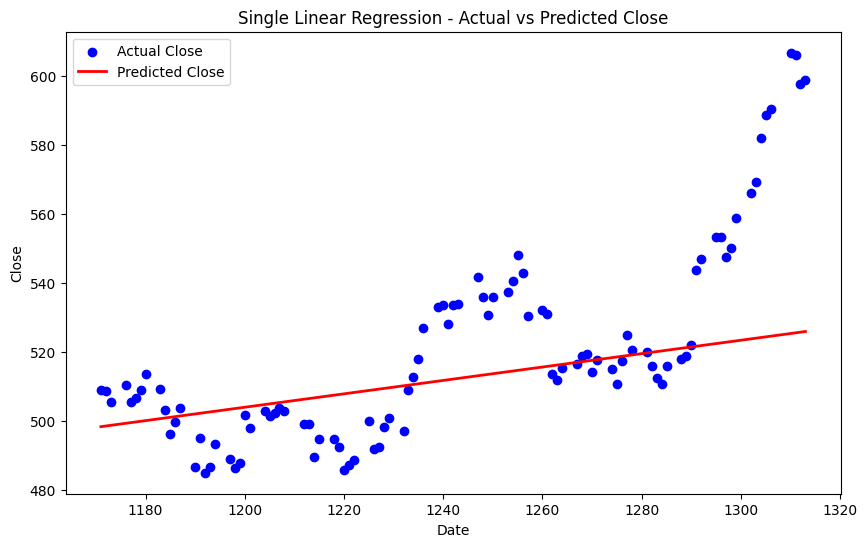

In [39]:
# Plot actual vs predicted values for single linear regression
plt.figure(figsize=(10, 6))
plt.scatter(X_val_single, y_val_single, color='blue', label='Actual Close')
plt.plot(X_val_single, y_val_pred_single, color='red', linewidth=2, label='Predicted Close')
plt.title('Single Linear Regression - Actual vs Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

## Best subset selection

In [40]:

# Select the relevant columns for best subset selection
features_subset = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
X_subset = df[features_subset]
y_subset = df['Close']

# Split the data into training, validation, and test sets (80:10:10)
X_train_subset, X_temp_subset, y_train_subset, y_temp_subset = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)
X_val_subset, X_test_subset, y_val_subset, y_test_subset = train_test_split(X_temp_subset, y_temp_subset, test_size=0.5, shuffle=False)

# Function to fit a model and calculate MSE for a subset of features
def fit_and_calculate_mse(features, X_train, X_val, y_train, y_val):
    X_train_subset_selected = X_train[features]
    X_val_subset_selected = X_val[features]

    X_train_subset_selected = sm.add_constant(X_train_subset_selected)
    X_val_subset_selected = sm.add_constant(X_val_subset_selected)

    model = sm.OLS(y_train, X_train_subset_selected).fit()
    y_pred_subset = model.predict(X_val_subset_selected)
    
    mse = mean_squared_error(y_val, y_pred_subset)
    
    return mse, model

# Perform best subset selection
all_features = features_subset
best_subset_mse = float('inf')
best_subset_features = []
best_subset_model = None

for k in range(1, len(all_features) + 1):
    subset_combinations = list(itertools.combinations(all_features, k))
    
    for subset in subset_combinations:
        mse, model = fit_and_calculate_mse(list(subset), X_train_subset, X_val_subset, y_train_subset, y_val_subset)
        
        if mse < best_subset_mse:
            best_subset_mse = mse
            best_subset_features = list(subset)
            best_subset_model = model

# Display the best subset and its MSE
print(f'Best Subset Features: {best_subset_features}')
print(f'Best Subset MSE: {best_subset_mse}')

# Summary of the best subset model
print(best_subset_model.summary())


Best Subset Features: ['Open', 'Adj Close']
Best Subset MSE: 2.7512969012825023e-27
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.819e+33
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:43:03   Log-Likelihood:                 24136.
No. Observations:                 807   AIC:                        -4.827e+04
Df Residuals:                     804   BIC:                        -4.825e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

## Multi Linear Regression

In [41]:
features_multi = ['Open', 'Adj Close']
X_multi = df[features_multi]
y_multi = df['Close']

total_size = len(df)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

# Split the data sequentially into training, validation, and test sets
X_train_multi = X_multi[:train_size]
y_train_multi = y_multi[:train_size]

X_val_multi = X_multi[train_size:train_size + val_size]
y_val_multi = y_multi[train_size:train_size + val_size]

X_test_multi = X_multi[train_size + val_size:]
y_test_multi = y_multi[train_size + val_size:]

# Initialize the Multi-linear Regression model
model_multi = LinearRegression()

# Train the model on the training set
model_multi.fit(X_train_multi, y_train_multi)

# Predict on the validation set
y_val_pred_multi = model_multi.predict(X_val_multi)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) on the validation set
mae_multi = mean_absolute_error(y_val_multi, y_val_pred_multi)
mse_multi = mean_squared_error(y_val_multi, y_val_pred_multi)

# Display relevant statistics for multi-linear regression
print(f'Multi-linear Regression:')
print(f'Mean Absolute Error (MAE) on validation set: {mae_multi}')
print(f'Mean Squared Error (MSE) on validation set: {mse_multi}')



Multi-linear Regression:
Mean Absolute Error (MAE) on validation set: 7.048583938740194e-14
Mean Squared Error (MSE) on validation set: 6.526972020926234e-27


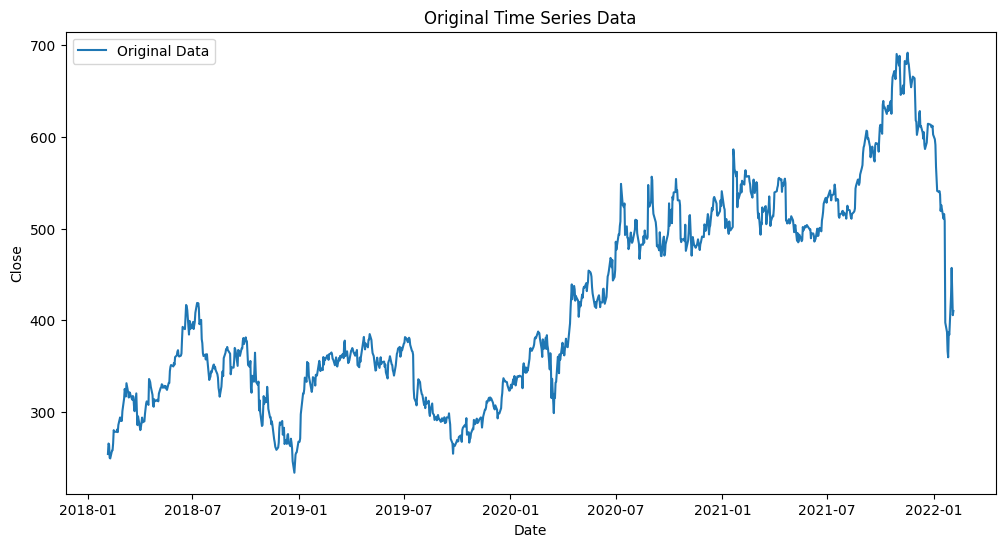

Root Mean Squared Error (RMSE) on Validation Set: 39.16470372803713
Mean Absolute Error (MAE) on Validation Set: 35.01147229704868
Mean Squared Error (MSE) on Validation Set: 1533.8740181049257


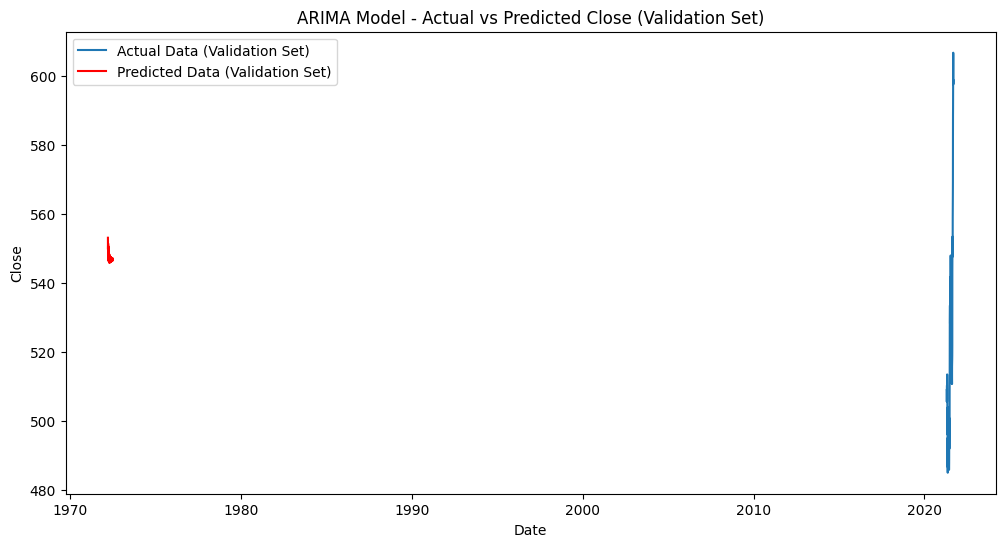

Root Mean Squared Error (RMSE) on Test Set: 92.66723149717461
Mean Absolute Error (MAE) on Test Set: 82.2424648580436
Mean Squared Error (MSE) on Test Set: 8587.215793350952


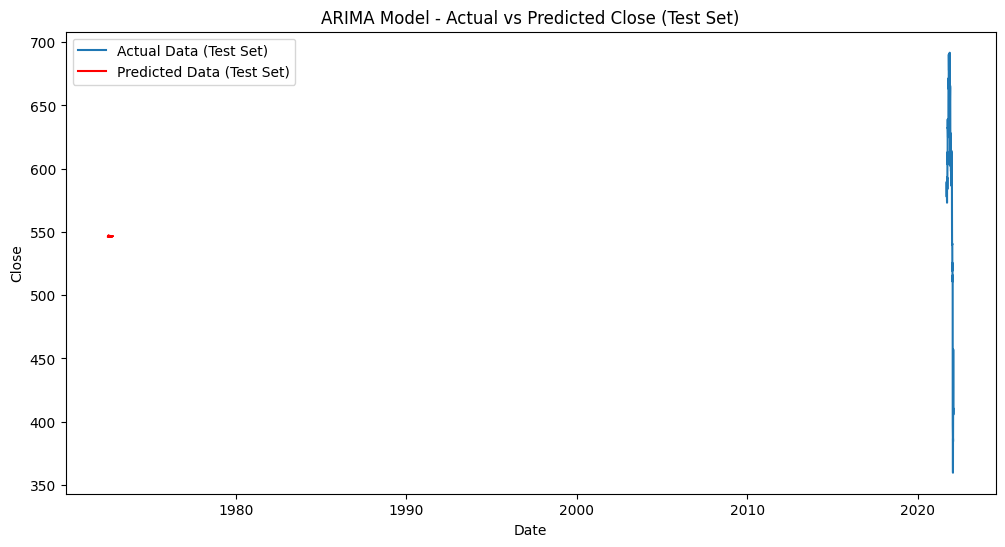

In [42]:

# Make sure the 'Date' column is set as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define the order (p, d, q) for the ARIMA model
order = (4, 1, 3)  # You can adjust these parameters based on model performance

# Split the data into training, validation, and test sets (80:10:10 split)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train, val, test = df[:train_size], df[train_size:train_size + val_size], df[train_size + val_size:]

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original Data')
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Train the ARIMA model on the training set
model = ARIMA(train['Close'], order=order)
fit_model = model.fit()

# Make predictions on the validation set
predictions_val = fit_model.predict(start=len(train), end=len(train) + len(val) - 1, typ='levels')

# Evaluate the model performance on the validation set
rmse_val = sqrt(mean_squared_error(val['Close'], predictions_val))
print(f'Root Mean Squared Error (RMSE) on Validation Set: {rmse_val}')
mae_val = mean_absolute_error(val['Close'], predictions_val)
mse_val = mean_squared_error(val['Close'], predictions_val)
print(f'Mean Absolute Error (MAE) on Validation Set: {mae_val}')
print(f'Mean Squared Error (MSE) on Validation Set: {mse_val}')

# Plot the actual vs predicted values on the validation set
plt.figure(figsize=(12, 6))
plt.plot(val['Close'], label='Actual Data (Validation Set)')
plt.plot(predictions_val, label='Predicted Data (Validation Set)', color='red')
plt.title('ARIMA Model - Actual vs Predicted Close (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Make predictions on the test set
predictions_test = fit_model.predict(start=len(train) + len(val), end=len(df) - 1, typ='levels')

# Evaluate the model performance on the test set
rmse_test = sqrt(mean_squared_error(test['Close'], predictions_test))
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse_test}')
mae_test = mean_absolute_error(test['Close'], predictions_test)
mse_test = mean_squared_error(test['Close'], predictions_test)
print(f'Mean Absolute Error (MAE) on Test Set: {mae_test}')
print(f'Mean Squared Error (MSE) on Test Set: {mse_test}')


# Plot the actual vs predicted values on the test set
plt.figure(figsize=(12, 6))
plt.plot(test['Close'], label='Actual Data (Test Set)')
plt.plot(predictions_test, label='Predicted Data (Test Set)', color='red')
plt.title('ARIMA Model - Actual vs Predicted Close (Test Set)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()
